In [2]:
from sys import maxsize

import numpy as np
import itertools
import math
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit import QuantumCircuit
#from qiskit import Aer

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
#from qiskit.providers.aer import QasmSimulator
import qiskit_aer.noise as noise
from qiskit.circuit.library import UnitaryGate

#My imports
from coolingUnitary import CoolingUnitary
from mirrorProtocol import MirrorProtocol
from pairingPartnerAlgorithm import PairingPartnerAlgorithm
from minimalWorkProtocol import MinimalWorkProtocol
from utils import *

In [3]:
backendName = "ibm_osaka"

In [4]:
service = QiskitRuntimeService()
sim_backend = service.backend(backendName)
qasm_sim = AerSimulator()

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.barrier()
circuit.x(qreg_q[0])
circuit.ccx(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.x(qreg_q[0])
circuit.barrier()
circuit.x(qreg_q[0])
circuit.x(qreg_q[2])
circuit.ccx(qreg_q[0], qreg_q[2], qreg_q[1])
circuit.x(qreg_q[0])
circuit.x(qreg_q[2])
circuit.barrier()
circuit.x(qreg_q[1])
circuit.x(qreg_q[2])
circuit.ccx(qreg_q[2], qreg_q[1], qreg_q[0])
circuit.x(qreg_q[1])
circuit.x(qreg_q[2])
circuit.barrier()
circuit.x(qreg_q[0])
circuit.x(qreg_q[2])
circuit.ccx(qreg_q[0], qreg_q[2], qreg_q[1])
circuit.x(qreg_q[0])
circuit.x(qreg_q[2])
circuit.barrier()
circuit.x(qreg_q[0])
circuit.ccx(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.x(qreg_q[0])
# @columns [1,1,1,2,3,4,5,5,5,6,6,7,8,8,9,9,9,10,10,11,12,12,13,13,13,14,14,15,16,16,17,17,17,18,19,20]

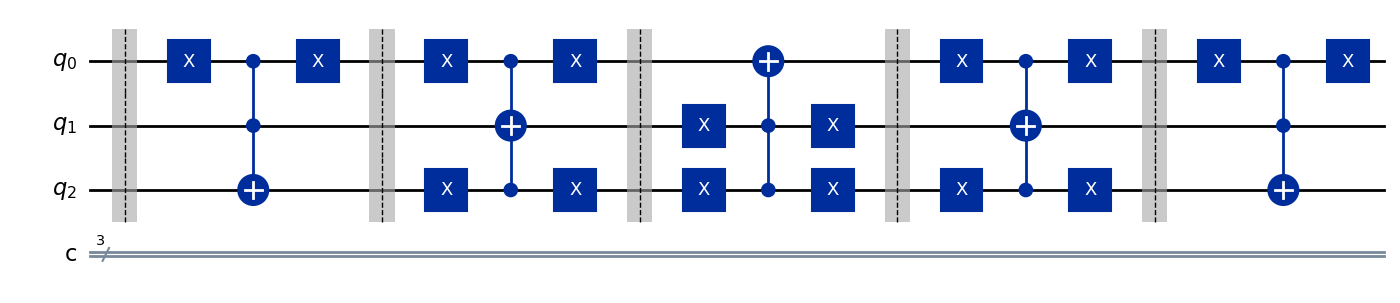

In [6]:
circuit.draw('mpl')

In [64]:
def permutationToCircuit(l):
    if(len(l) > 0):
        numQubit = len(l[0][0])
        qreg_q = QuantumRegister(numQubit, 'q')
        creg_c = ClassicalRegister(numQubit, 'c')
        finalCircuit = QuantumCircuit(qreg_q, creg_c)
        finalCircuit.barrier()
        for i in range(len(l)):
            stateIn = l[i][0]
            stack = []
            for j in range(numQubit-1,-1,-1):
                circuit = QuantumCircuit(qreg_q)
                if(l[i][0][j] != l[i][1][j]):
                    
                    #Add X gates when the qubit is in the state 0 so all control are in the 1 state
                    for z in range(len(stateIn)):
                        if(z != j):
                            if(stateIn[z] == '0'):
                                circuit.x(z)

                    
                    #MCX Gate with target in the J position and control in the rest of the qubits
                    rangeOfMCX = list(range(0,j)) + list(range(j+1,numQubit))
                    #print(rangeOfMCX)
                    #print(l[i][0][j] + " " + l[i][1][j])
                    circuit.mcx(list(rangeOfMCX),j)

                    #Add X gates when the qubit is in the state 0 so all control are in the 1 state
                    for z in range(len(stateIn)):
                        if(z != j):
                            if(stateIn[z] == '0'):
                                circuit.x(z)

                    #Change the state in to match the state after applying the gate
                    if(stateIn[j] == '0'):
                        stateIn = stateIn[:j] + '1' + stateIn[j + 1:]
                    else:
                        stateIn = stateIn[:j] + '0' + stateIn[j + 1:]

                    circuit.barrier()

                    stack.append(circuit)
                    finalCircuit = finalCircuit.compose(circuit)

           
            #Using the stack we create the uncomputation circuit
            #We discard the first element since we don't need it for the uncompuation
            stack.pop()
            while(len(stack)):
                finalCircuit = finalCircuit.compose(stack.pop())

    return finalCircuit

In [ ]:
def testCircuit(circuit):
    
    n = circuit.num_qubits
    num_circs = 2**n
    circuits = []
    q_regs = QuantumRegister(n, 'q')
    c_regs = ClassicalRegister(n, 'c')
    #make circuits
    for i in range(num_circs):
        total_circ = QuantumCircuit(q_regs, c_regs)
        #prepare initial state
        bitstring = format(i,'b').zfill(n)
        idx = 0
        for bit in bitstring[::-1]:
        #for bit in bitstring:
            if (bit == '1'):
                total_circ.x(idx)
            idx += 1
        total_circ.barrier()
        #add cooling circuits
        total_circ.compose(circuit, qubits=[q_regs[2],q_regs[1],q_regs[0]], inplace=True)
        #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2],q_regs[3],q_regs[4]], inplace=True)
        #add measurement
        total_circ.barrier()
        total_circ.measure(range(n), c_regs)
        #total_circ.measure(0, c_regs)
        #transpiledCircuit = qk.transpile(total_circ, backend=sim_backend,optimization_level=3)
        circuits.append(total_circ)

In [68]:
l = [["011","100"]]

c = permutationToCircuit(l)
c.draw()

c.compose(c)

c.draw()

c.num_qubits

3

In [15]:
n = 3
num_circs = 2**n
circuits = []
q_regs = qk.QuantumRegister(n, 'q')
c_regs = qk.ClassicalRegister(n, 'c')
#make circuits
for i in range(num_circs):
    total_circ = qk.QuantumCircuit(q_regs, c_regs)
    #prepare initial state
    bitstring = format(i,'b').zfill(n)
    idx = 0
    for bit in bitstring[::-1]:
    #for bit in bitstring:
        if (bit == '1'):
            total_circ.x(idx)
        idx += 1
    total_circ.barrier()
    #add cooling circuits
    total_circ.compose(circuit, qubits=[q_regs[2],q_regs[1],q_regs[0]], inplace=True)
    #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2],q_regs[3],q_regs[4]], inplace=True)
    #add measurement
    total_circ.barrier()
    total_circ.measure(range(n), c_regs)
    #total_circ.measure(0, c_regs)
    transpiledCircuit = qk.transpile(total_circ, backend=sim_backend,optimization_level=3)
    circuits.append(transpiledCircuit)

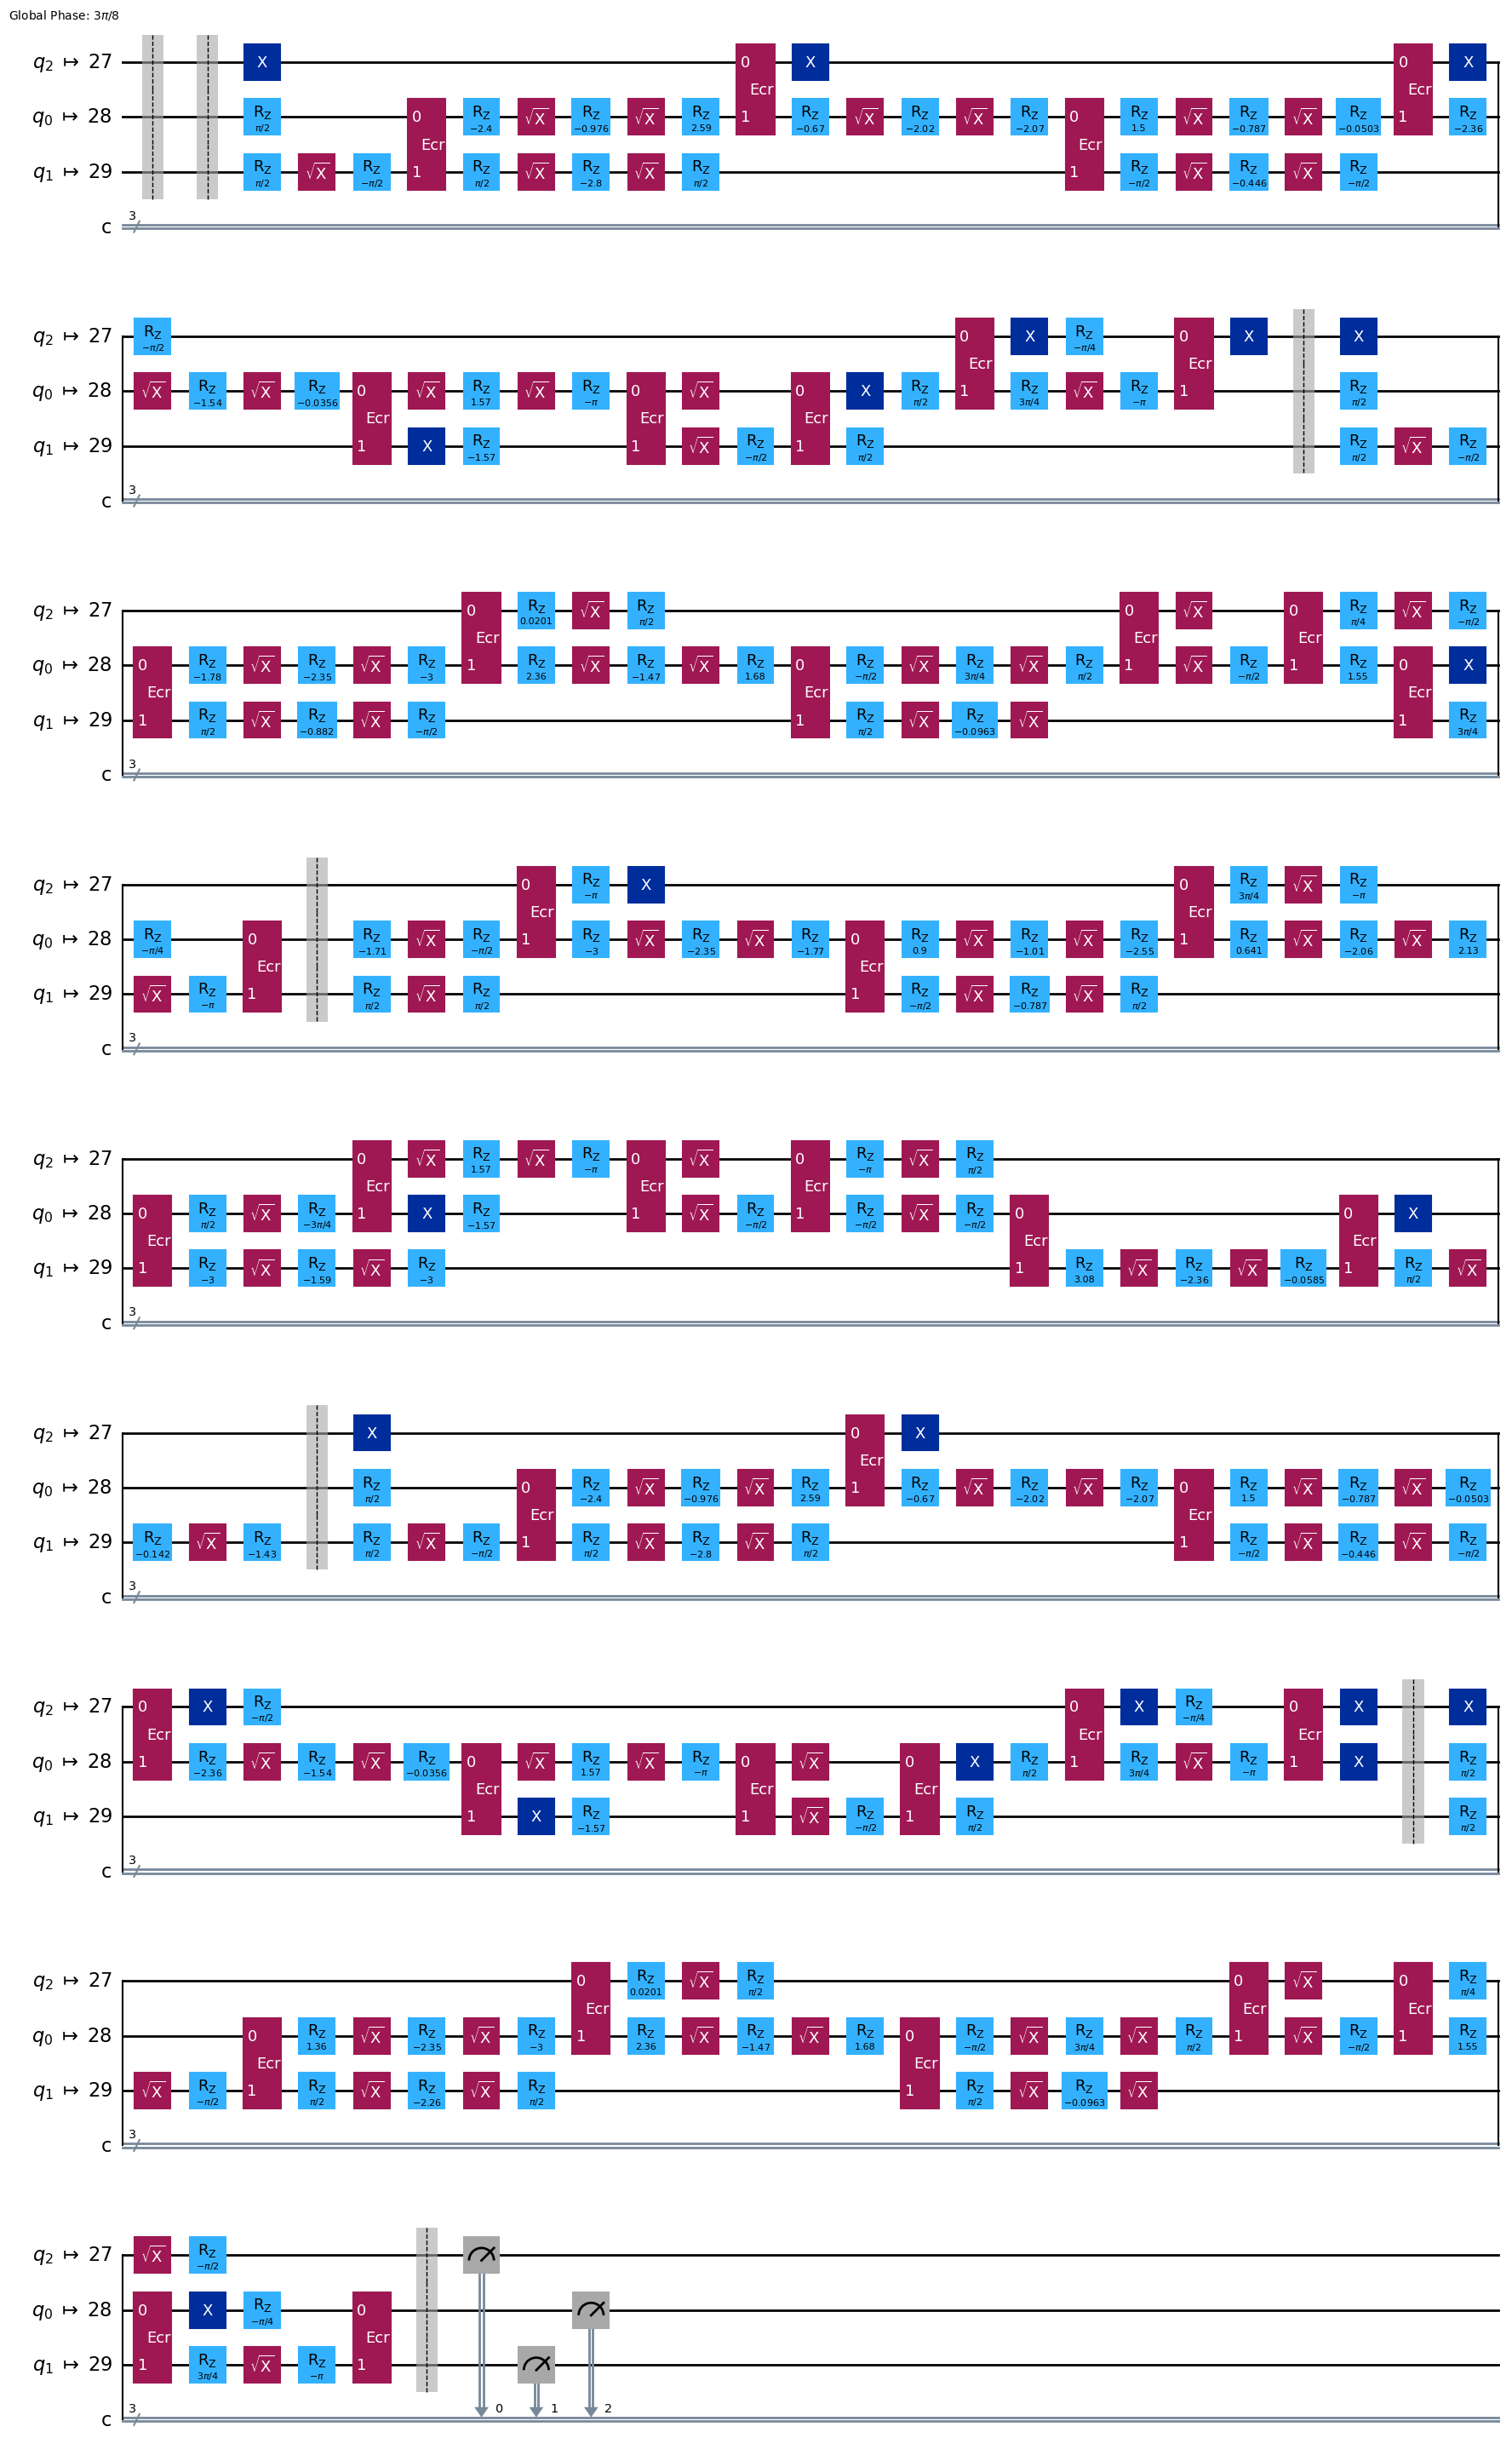

In [16]:
circuits[0].draw('mpl',idle_wires=False)

In [22]:
circuits[0].count_ops()

OrderedDict([('rz', 152),
             ('sx', 92),
             ('ecr', 41),
             ('x', 22),
             ('barrier', 7),
             ('measure', 3)])

In [21]:
counts = []
for i in range(num_circs):
    result = qasm_sim.run(circuits[i]).result()
    counts.append(result.get_counts())
    print(format(i,'b').zfill(n) + " " + str(counts[i]))

000 {'000': 1024}
001 {'001': 1024}
010 {'010': 1024}
011 {'100': 1024}
100 {'011': 1024}
101 {'101': 1024}
110 {'110': 1024}
111 {'111': 1024}


In [171]:
n = 5
a = MinimalWorkProtocol(n,0.01)
checkUnitary(a)
cooling_circuit = QuantumCircuit(n)
cooling_circuit.append(UnitaryGate(a),range(n))


0 | 00000 --> 00000
1 | 00001 --> 00001
2 | 00010 --> 00010
3 | 00011 --> 10000 (*)
4 | 00100 --> 00100
5 | 00101 --> 00101
6 | 00110 --> 00110
7 | 00111 --> 11000 (*)
8 | 01000 --> 01000
9 | 01001 --> 01001
10 | 01010 --> 01010
11 | 01011 --> 10100 (*)
12 | 01100 --> 01100
13 | 01101 --> 10010 (*)
14 | 01110 --> 10001 (*)
15 | 01111 --> 00011 (*)
-------------------------
16 | 10000 --> 11100 (*)
17 | 10001 --> 01110 (*)
18 | 10010 --> 01101 (*)
19 | 10011 --> 10011
20 | 10100 --> 01011 (*)
21 | 10101 --> 10101
22 | 10110 --> 10110
23 | 10111 --> 10111
24 | 11000 --> 00111 (*)
25 | 11001 --> 11001
26 | 11010 --> 11010
27 | 11011 --> 11011
28 | 11100 --> 01111 (*)
29 | 11101 --> 11101
30 | 11110 --> 11110
31 | 11111 --> 11111


In [172]:
num_circs = 2**n
circuits = []
q_regs = qk.QuantumRegister(n, 'q')
c_regs = qk.ClassicalRegister(n, 'c')
#make circuits
for i in range(num_circs):
    total_circ = qk.QuantumCircuit(q_regs, c_regs)
    #prepare initial state
    bitstring = format(i,'b').zfill(n)
    idx = 0
    for bit in bitstring[::-1]:
    #for bit in bitstring:
        if (bit == '1'):
            total_circ.x(idx)
        idx += 1
    total_circ.barrier()
    #add cooling circuits
    #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2]], inplace=True)
    total_circ.compose(cooling_circuit, inplace=True)
    #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2],q_regs[3],q_regs[4]], inplace=True)
    #add measurement
    total_circ.barrier()
    total_circ.measure(range(n), c_regs)
    transpiledCircuitUnitary = qk.transpile(total_circ, backend=sim_backend,optimization_level=3)
    #total_circ.measure(0, c_regs)
    circuits.append(transpiledCircuitUnitary)

In [173]:
circuits[0].draw('mpl',idle_wires=False)

ValueError: Image size of 2281x104129 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2281.67x104129 with 1 Axes>

In [176]:
circuits[0].count_ops()

OrderedDict([('rz', 3342),
             ('sx', 2505),
             ('ecr', 966),
             ('x', 175),
             ('measure', 5),
             ('barrier', 2)])

# QUA QUA QUA

In [209]:
counts = []

for i in range(num_circs):
    result = qasm_sim.run(circuits[i],shots = 1).result()
    counts.append(result.get_counts())
    #print(i, list(counts[i])[0])
    if(format(i,'b').zfill(n) == list(counts[i])[0]):
        print(format(i).zfill(num_circs % 10) + " | " + format(i,'b').zfill(n) + " --> " + str(list(counts[i])[0]))
    else:
        print(format(i).zfill(num_circs % 10) + " | " + format(i,'b').zfill(n) + " --> " + str(list(counts[i])[0]) + " (*)")


00 | 00000 --> 00000
01 | 00001 --> 00001
02 | 00010 --> 00010
03 | 00011 --> 10000 (*)
04 | 00100 --> 00100
05 | 00101 --> 00101
06 | 00110 --> 00110
07 | 00111 --> 11000 (*)
08 | 01000 --> 01000
09 | 01001 --> 01001
10 | 01010 --> 01010
11 | 01011 --> 10100 (*)
12 | 01100 --> 01100
13 | 01101 --> 10010 (*)
14 | 01110 --> 10001 (*)
15 | 01111 --> 00011 (*)
16 | 10000 --> 11100 (*)
17 | 10001 --> 01110 (*)
18 | 10010 --> 01101 (*)
19 | 10011 --> 10011
20 | 10100 --> 01011 (*)
21 | 10101 --> 10101
22 | 10110 --> 10110
23 | 10111 --> 10111
24 | 11000 --> 00111 (*)
25 | 11001 --> 11001
26 | 11010 --> 11010
27 | 11011 --> 11011
28 | 11100 --> 01111 (*)
29 | 11101 --> 11101
30 | 11110 --> 11110
31 | 11111 --> 11111


In [178]:
num_circs = 2**n
circuits = []
q_regs = qk.QuantumRegister(n, 'q')
c_regs = qk.ClassicalRegister(n, 'c')
#make circuits
for i in range(num_circs):
    total_circ = qk.QuantumCircuit(q_regs, c_regs)
    #prepare initial state
    bitstring = format(i,'b').zfill(n)
    idx = 0
    for bit in bitstring[::-1]:
    #for bit in bitstring:
        if (bit == '1'):
            total_circ.x(idx)
        idx += 1
    total_circ.barrier()
    #add cooling circuits
    #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2]], inplace=True)
    total_circ.compose(cooling_circuit, inplace=True)
    #total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2],q_regs[3],q_regs[4]], inplace=True)
    #add measurement
    total_circ.barrier()
    total_circ.measure(range(n), c_regs)
    #transpiledCircuitUnitary = qk.transpile(total_circ, backend=sim_backend,optimization_level=3)
    #total_circ.measure(0, c_regs)
    circuits.append(total_circ)

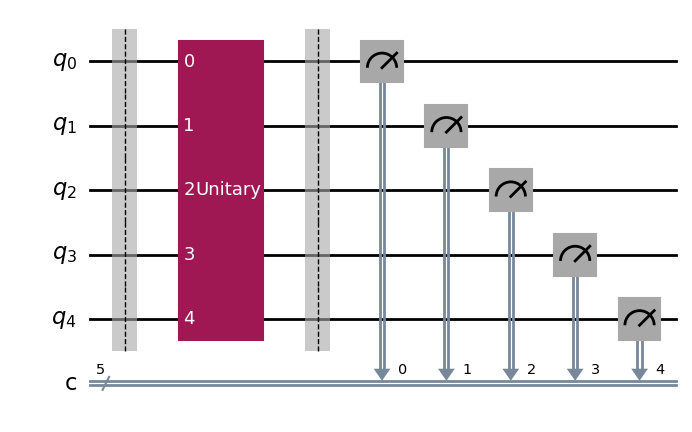

In [179]:
circuits[0].draw('mpl',idle_wires=False)

In [180]:
transpiledCircuitUnitary = qk.transpile(circuits, backend=sim_backend,optimization_level=3)

In [1]:
transpiledCircuitUnitary[0].draw(idle_wires=False)

NameError: name 'transpiledCircuitUnitary' is not defined